## Before anything please install all needed requirements via the below command
`conda create --name <envname> --file requirements.txt`

# Fine Tuning BERT Trained on 100M+ Patents for MultiLabel Text Classification

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU. 

In [1]:
# Importing stock ml libraries
import os

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoModelForMaskedLM




import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 1995

# sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 1995


1995

In [2]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
print(device)

cuda


<a id='section02'></a>
### Importing and Pre-Processing the Patent data


In [4]:
df_2009 = pd.read_csv('/home/chikkamath/gppd/2009.csv')
df_2010 = pd.read_csv('/home/chikkamath/gppd/2010.csv')
df_2011 = pd.read_csv('/home/chikkamath/gppd/2011.csv')
df_2012 = pd.read_csv('/home/chikkamath/gppd/2012.csv')
df_2013 = pd.read_csv('/home/chikkamath/gppd/2013.csv')
df_2014 = pd.read_csv('/home/chikkamath/gppd/2014.csv')
df_2015 = pd.read_csv('/home/chikkamath/gppd/2015.csv')
df_2016 = pd.read_csv('/home/chikkamath/gppd/2016.csv')
df_2017 = pd.read_csv('/home/chikkamath/gppd/2017.csv')
df_2018 = pd.read_csv('/home/chikkamath/gppd/2018.csv')
df_2019 = pd.read_csv('/home/chikkamath/gppd/2019.csv')

df = pd.concat([df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019], axis=0, ignore_index=True)

In [5]:
df.tail()

,Unnamed: 0,ID,Date,Title,Claim,cpc_subclass
2872342,200447,10365930,2019-07-30,Instructions for managing a parallel cache hie...,"1. A method, comprising: receiving an instruct...",G06F
2872343,200448,10365893,2019-07-30,Sample-based multidimensional data cloning,1. A computer-implemented method in a distribu...,G06F
2872344,200449,10366004,2019-07-30,Storage system with elective garbage collectio...,1. A method for elective garbage collection in...,G06F
2872345,200450,10363133,2019-07-30,Methods and apparatus for engaging a valve pro...,"1. A system for deploying a prosthetic valve, ...",A61F
2872346,200451,10364934,2019-07-30,Support structure for supporting a conduit of ...,1. A support structure for supporting a condui...,F16M


In [6]:
df.rename(columns={"Claim":"Abstract", "cpc_subclass":"Subclass_labels"}, inplace=True)
df.head()

,Unnamed: 0,ID,Date,Title,Abstract,Subclass_labels
0,0,7473268,2009-01-06,Mating insertion instruments for spinal implan...,1. A method for inserting a main body assembly...,"A61B,A61K"
1,1,7473683,2009-01-06,Nonpolar thymidine analogs,1. A nucleoside analog comprising a halogenate...,"A61K,C07D,C07H"
2,2,7473560,2009-01-06,Steroid hormone analysis by mass spectrometry,1. A method for mass spectrometric analysis of...,"G01N,Y10T"
3,3,7472455,2009-01-06,Portable hairstylists' station and method,1. A portable hair stylists' station having a ...,"A45D,A47L"
4,4,7474526,2009-01-06,Electronic apparatus,1. An electronic apparatus comprising: a case;...,"G06F,H01L"


# of lables is: 2557


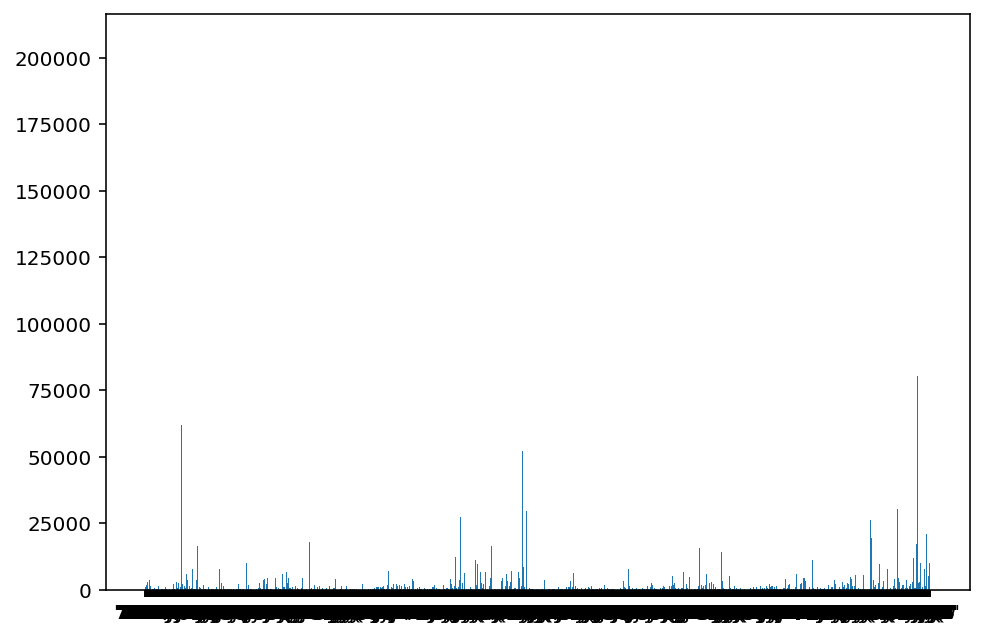

In [7]:
labels = str(df.iloc[:len(df)-len(df_2015)]['Subclass_labels'].tolist()).replace('[', '').replace(']', '').replace(' ', '').split(',')


val, counts = np.unique(labels, return_counts=True)

print('# of lables is: '+str(len(val)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

# of lables is: 2406


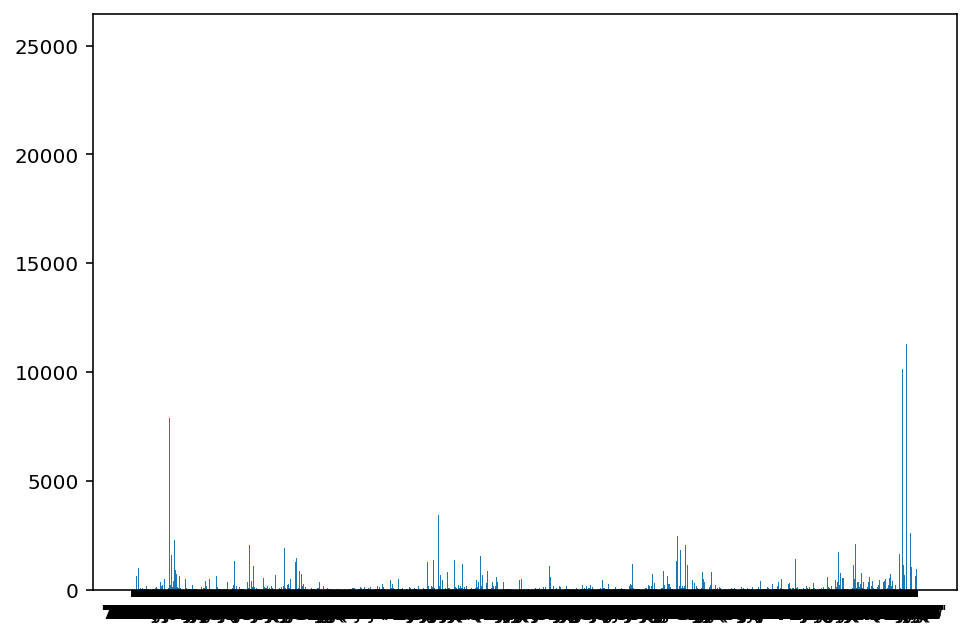

In [8]:
labels = str(df_2015['cpc_subclass'].tolist()).replace('[', '').replace(']', '').replace(' ', '').split(',')


val, counts = np.unique(labels, return_counts=True)

print('# of lables is: '+str(len(val)))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

In [9]:
print(df.shape)
df.head()

(2872347, 6)


,Unnamed: 0,ID,Date,Title,Abstract,Subclass_labels
0,0,7473268,2009-01-06,Mating insertion instruments for spinal implan...,1. A method for inserting a main body assembly...,"A61B,A61K"
1,1,7473683,2009-01-06,Nonpolar thymidine analogs,1. A nucleoside analog comprising a halogenate...,"A61K,C07D,C07H"
2,2,7473560,2009-01-06,Steroid hormone analysis by mass spectrometry,1. A method for mass spectrometric analysis of...,"G01N,Y10T"
3,3,7472455,2009-01-06,Portable hairstylists' station and method,1. A portable hair stylists' station having a ...,"A45D,A47L"
4,4,7474526,2009-01-06,Electronic apparatus,1. An electronic apparatus comprising: a case;...,"G06F,H01L"


In [7]:
new_df = df.copy()
new_df.head()

,Unnamed: 0,ID,Date,Title,Abstract,Subclass_labels
0,0,7473268,2009-01-06,Mating insertion instruments for spinal implan...,1. A method for inserting a main body assembly...,"A61B,A61K"
1,1,7473683,2009-01-06,Nonpolar thymidine analogs,1. A nucleoside analog comprising a halogenate...,"A61K,C07D,C07H"
2,2,7473560,2009-01-06,Steroid hormone analysis by mass spectrometry,1. A method for mass spectrometric analysis of...,"G01N,Y10T"
3,3,7472455,2009-01-06,Portable hairstylists' station and method,1. A portable hair stylists' station having a ...,"A45D,A47L"
4,4,7474526,2009-01-06,Electronic apparatus,1. An electronic apparatus comprising: a case;...,"G06F,H01L"


In [8]:
abstracts = new_df.Abstract.values
titles = new_df.Title.values

for i in range(len(abstracts)):
    abstracts[i] = titles[i] + ' : ' + abstracts[i]
    

new_df.Abstract = abstracts

y = [label.split(',') for label in new_df['Subclass_labels'].values]
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(y)
new_df['Subclass_labels'] = y_binarized.tolist()

new_df.head()

,Unnamed: 0,ID,Date,Title,Abstract,Subclass_labels
0,0,7473268,2009-01-06,Mating insertion instruments for spinal implan...,Mating insertion instruments for spinal implan...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,7473683,2009-01-06,Nonpolar thymidine analogs,Nonpolar thymidine analogs : 1. A nucleoside a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,7473560,2009-01-06,Steroid hormone analysis by mass spectrometry,Steroid hormone analysis by mass spectrometry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,7472455,2009-01-06,Portable hairstylists' station and method,Portable hairstylists' station and method : 1....,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,7474526,2009-01-06,Electronic apparatus,Electronic apparatus : 1. An electronic appara...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
LABEL_COLUMNS = mlb.classes_
LABEL_COLUMNS
print(len(LABEL_COLUMNS))

664


In [10]:
new_df = new_df[['Abstract', 'Subclass_labels']].copy()
new_df.head()

,Abstract,Subclass_labels
0,Mating insertion instruments for spinal implan...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Nonpolar thymidine analogs : 1. A nucleoside a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Steroid hormone analysis by mass spectrometry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Portable hairstylists' station and method : 1....,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Electronic apparatus : 1. An electronic appara...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
print("Average text length is: "+str(sum(new_df.Abstract.apply(lambda x: len(x.split())))/len(new_df)))
print("Max text lenght is : "+str(max(new_df.Abstract.apply(lambda x: len(x.split())))))

Average text length is: 170.98964017926804
Max text lenght is : 12171


### Text length distribution

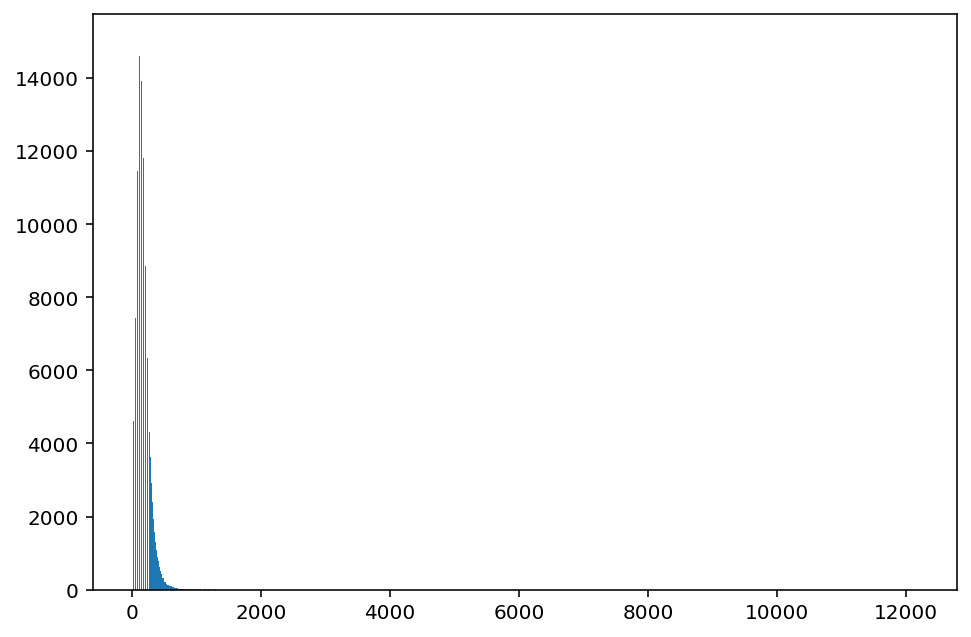

In [15]:
length = new_df.Abstract.apply(lambda x: len(x.split()))
                      

val, counts = np.unique(length, return_counts=True)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(val,counts)
plt.show()

<a id='section03'></a>
### Preparing the Dataset and Dataloader


#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training. 
- We are using the BERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`
---
- *This is the first difference between the distilbert and bert, where the tokenizer generates the token_type_ids in case of Bert*
---
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)
- `targest` is the list of categories labled as `0` or `1` in the dataframe. 
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset 2006-2014* is used to fine tune the model
- *Validation Dataset 2015* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128
EPOCHS = 4
LEARNING_RATE = 3e-05

BERT_MODEL_NAME = 'anferico/bert-for-patents'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [12]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.Abstract
        self.targets = self.data.Subclass_labels
        self.max_len = max_len
        try:
            self.title = dataframe.Title
        except:
            self.title = None

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        
        try:
            tokenized_text = {}
            text = str(self.text[index])
            text = " ".join(text.split())
            if self.title is not None:
                title = str(self.title[index])
                title = " ".join(title.split())

                inputs = self.tokenizer.encode_plus(
                title,
                None,
                add_special_tokens=True,
                max_length=self.max_len,
                pad_to_max_length=True,
                return_token_type_ids=True
                )

                ids = inputs['input_ids']
                mask = inputs['attention_mask']
                token_type_ids = inputs["token_type_ids"]


                tokenized_text = {
                    'ids_title': torch.tensor(ids, dtype=torch.long),
                    'mask_title': torch.tensor(mask, dtype=torch.long),
                    'token_type_ids_title': torch.tensor(token_type_ids, dtype=torch.long),
                }

            inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=self.max_len,
                pad_to_max_length=True,
                return_token_type_ids=True
            )
            ids = inputs['input_ids']
            mask = inputs['attention_mask']
            token_type_ids = inputs["token_type_ids"]



            tokenized_text['input_ids'] = torch.tensor(ids, dtype=torch.long)
            tokenized_text['attention_mask'] = torch.tensor(mask, dtype=torch.long)
            tokenized_text['token_type_ids'] = torch.tensor(token_type_ids, dtype=torch.long)
            tokenized_text['labels'] = torch.tensor(self.targets[index], dtype=torch.float)
        except:
            pass
        return tokenized_text
        

In [13]:
class PatentDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = CustomDataset(
          self.train_df,
          self.tokenizer,
          self.max_token_len
        )

        self.test_dataset = CustomDataset(
          self.test_df,
          self.tokenizer,
          self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True,
          num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          num_workers=2
        )

In [14]:
# Creating the dataset and dataloader for the neural network

TRAIN_SIZE = len(df)
TEST_SIZE = 49900

train_dataset = new_df.iloc[:TRAIN_SIZE-TEST_SIZE]
test_dataset = new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

# train_dataset = train_dataset.sample(TRAIN_SIZE).reset_index(drop=True)
# test_dataset = test_dataset.sample(TEST_SIZE).reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2872347, 2)
TRAIN Dataset: (2822447, 2)
TEST Dataset: (49900, 2)


In [15]:
train_dataset.head()

,Abstract,Subclass_labels
0,Mating insertion instruments for spinal implan...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Nonpolar thymidine analogs : 1. A nucleoside a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Steroid hormone analysis by mass spectrometry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Portable hairstylists' station and method : 1....,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Electronic apparatus : 1. An electronic appara...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
BATCH_SIZE = 54

data_module = PatentDataModule(
  train_dataset,
  test_dataset,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_LEN
)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`. 
 - This network will have the `Bert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.
 
#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`. 

In [17]:
class PatentTagger(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        
            
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)    
#         loss = 0
#         if labels is not None:
#             loss = self.criterion(output, labels)
        return output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(input_ids, attention_mask, labels)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return loss
#         return {"loss": loss, "predictions": outputs, "labels": labels}


    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(input_ids, attention_mask, labels)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss.detach().item(), prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(input_ids, attention_mask, labels)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss.detach().item(), prog_bar=True, logger=True)
#         return loss

#     def training_epoch_end(self, outputs):

#         labels = []
#         predictions = []
#         for output in outputs:
#             for out_labels in output["labels"].detach().cpu():
#                 labels.append(out_labels)
#             for out_predictions in output["predictions"].detach().cpu():
#                 predictions.append(out_predictions)

#         labels = torch.stack(labels).int()
#         predictions = torch.stack(predictions)

#         for i, name in enumerate(LABEL_COLUMNS):
#             class_roc_auc = auroc(predictions[:, i], labels[:, i])
#             self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )

        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )

In [18]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


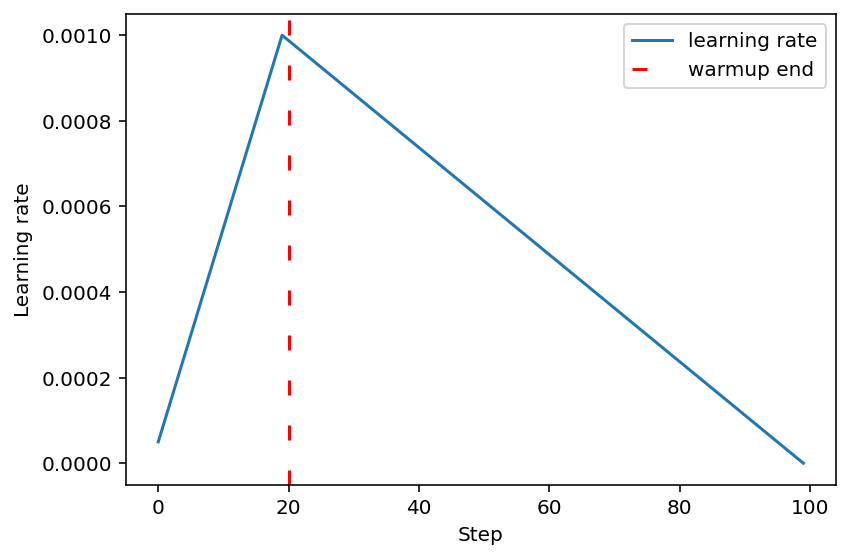

In [19]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [20]:
steps_per_epoch=len(train_dataset) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS

In [21]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(41813, 209068)

In [22]:
model = PatentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# !rm -rf lightning_logs_gppd/
# !rm -rf checkpoints/

In [24]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs_gppd

In [23]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [24]:
logger = TensorBoardLogger("lightning_logs_gppd", name="patent-tagger_gppd")

In [25]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process. 

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.


In [26]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6443522820>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6443522820>)`.
  rank_zero_deprecation(
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tra

In [27]:
trainer.fit(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 344 M 
1 | classifier | Linear    | 680 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
345 M     Trainable params
0         Non-trainable params
345 M     Total params
1,381.534 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed

Training: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding

Validation: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is prov

Validation: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is prov

Validation: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is prov

Validation: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is prov

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the subset of `train.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

### Threshold

In [28]:
print(trainer.checkpoint_callback.best_model_path)

trained_model = PatentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
#     checkpoint_path="lightning_logs_gppd_0/patent-tagger_gppd_0/version_3/checkpoints/epoch=2-step=46875.ckpt",
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

lightning_logs_gppd/patent-tagger_gppd/version_4/checkpoints/epoch=3-step=209072.ckpt


Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = CustomDataset(
  test_dataset,
  tokenizer,
  MAX_LEN
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())


In [30]:
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [31]:
print("AUROC per tag")
aurocs = []
for i, name in enumerate(LABEL_COLUMNS):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    aurocs.append(tag_auroc)
    print(f"{name}: {tag_auroc}")

AUROC per tag
A01B: 0.998320460319519
A01C: 0.9986821413040161
A01D: 0.9938939809799194
A01F: 0.9885736703872681
A01G: 0.9864836931228638
A01H: 0.997439444065094
A01J: 1.0
A01K: 0.9903620481491089
A01L: 1.0
A01M: 0.9868595600128174
A01N: 0.9934536218643188
A21B: 0.9998562932014465
A21C: 0.9998421669006348
A21D: 0.9994169473648071
A22B: 0.999652624130249
A22C: 0.994580864906311
A23B: 0.9939133524894714
A23C: 0.9677369594573975
A23D: 0.9996838569641113
A23F: 0.9993816614151001
A23G: 0.9984362721443176
A23J: 0.9991891384124756
A23K: 0.9873092174530029
A23L: 0.994644284248352
A23N: 0.9939204454421997
A23P: 0.997766375541687
A23V: 0.9937869906425476
A23Y: 0.9998196363449097
A24B: 0.9885553121566772
A24C: 0.9999879598617554
A24D: 0.9999651908874512
A24F: 0.9970468282699585
A41B: 0.9957544803619385
A41C: 0.9994825124740601
A41D: 0.9913801550865173
A41F: 0.9972484111785889
A41G: 0.9891296625137329
A41H: 0.9986047744750977
A42B: 0.9992313385009766
A42C: 0.99407958984375
A43B: 0.9967815279960632

/home/chikkamath/anaconda3/envs/patent_pytorch/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


B21G: 0.0
B21H: 0.9978330135345459
B21J: 0.995513916015625
B21K: 0.9970625638961792
B21L: 0.0
B22C: 0.9928258061408997
B22D: 0.9881746768951416
B22F: 0.9940153360366821
B23B: 0.9933511018753052
B23C: 0.993815004825592
B23D: 0.9835293292999268
B23F: 0.9998997449874878
B23G: 0.9994856119155884
B23H: 0.9924341440200806
B23K: 0.9885013103485107
B23P: 0.9756797552108765
B23Q: 0.9921684265136719
B24B: 0.9799351096153259
B24C: 0.9966028928756714
B24D: 0.9998586177825928
B25B: 0.9967074990272522
B25C: 0.9997666478157043
B25D: 0.9992139339447021
B25F: 0.9926581978797913
B25G: 0.995525598526001
B25H: 0.9974112510681152
B25J: 0.9828569293022156
B26B: 0.9971011877059937
B26D: 0.9975179433822632
B26F: 0.9716014862060547
B27B: 0.9824361801147461
B27C: 0.9992284178733826
B27D: 0.9963725805282593
B27F: 0.999879777431488
B27G: 0.9984394907951355
B27H: 0.9237058758735657
B27J: 0.0
B27K: 0.9999372959136963
B27L: 0.9973345994949341
B27M: 0.9984067678451538
B27N: 0.9997460842132568
B28B: 0.9946107864379883

In [32]:
print(f"Average AUROC is {sum(aurocs)/len(aurocs)}")

Average AUROC is 0.9395003914833069


In [49]:
THRESHOLD = 0.9

In [50]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
    digits=4
))

              precision    recall  f1-score   support

        A01B     0.9000    0.1875    0.3103        48
        A01C     1.0000    0.4082    0.5797        49
        A01D     0.9512    0.5417    0.6903        72
        A01F     1.0000    0.3571    0.5263        28
        A01G     0.9583    0.3932    0.5576       117
        A01H     1.0000    0.8427    0.9146       178
        A01J     1.0000    0.5882    0.7407        17
        A01K     0.9810    0.5074    0.6688       203
        A01L     0.0000    0.0000    0.0000         1
        A01M     1.0000    0.4167    0.5882        60
        A01N     0.9333    0.3723    0.5323       188
        A21B     0.0000    0.0000    0.0000         6
        A21C     1.0000    0.1250    0.2222         8
        A21D     1.0000    0.0909    0.1667        11
        A22B     0.0000    0.0000    0.0000         3
        A22C     0.8000    0.5000    0.6154         8
        A23B     1.0000    0.0455    0.0870        22
        A23C     1.0000    

### Top@K

In [59]:
K = 5
pred = torch.zeros_like(predictions)
_, top_k = torch.topk(predictions, K)

pred = pred.numpy()
top_k = top_k.numpy()
np.put_along_axis(pred, top_k, 1, axis=1)

In [60]:
y_pred = pred
y_true = labels.numpy()


print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0,
    digits=4
))

              precision    recall  f1-score   support

        A01B     0.2794    0.7917    0.4130        48
        A01C     0.5479    0.8163    0.6557        49
        A01D     0.4507    0.8889    0.5981        72
        A01F     0.4310    0.8929    0.5814        28
        A01G     0.4049    0.7094    0.5155       117
        A01H     0.8259    0.9326    0.8760       178
        A01J     0.8500    1.0000    0.9189        17
        A01K     0.5065    0.7635    0.6090       203
        A01L     0.3333    1.0000    0.5000         1
        A01M     0.5000    0.7167    0.5890        60
        A01N     0.5227    0.7340    0.6106       188
        A21B     0.1562    0.8333    0.2632         6
        A21C     0.3636    1.0000    0.5333         8
        A21D     0.2273    0.4545    0.3030        11
        A22B     0.2000    0.6667    0.3077         3
        A22C     0.2400    0.7500    0.3636         8
        A23B     0.4815    0.5909    0.5306        22
        A23C     0.3125    